In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px

import re
import regex
import emoji
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

# De txt a tabla

## Funciones

In [3]:
def IniciaConFechaYHora(s):
    # Ejemplo: '2/10/2018, 9:38 p. m. - ... '
    patron = '^([1-9]|1[0-9]|2[0-9]|3[0-1])(\/)([1-9]|1[0-2])(\/)(2[0-9][0-9][0-9]), ([0-9]|0[0-9]|1[0-2]):([0-9][0-9])\u202f(p.\u202fm.|a.\u202fm.) -'
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de fecha y hora
    if resultado:
        return True
    return False

In [4]:
# Patron para encontrar a los miembros del grupo dentro del txt
def EncontrarMiembro(s):
    patrones = [
        '([\w]+):',                                    # Nombre
        '([\w]+[\s]+[\(]+[\w]+[\)]+):',      # Nombre (Apodo)
        '([\w]+[\s]+[\w]+):',                    # Nombre + Apellido
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # Nombre 1 + Nombre 2 + Apellido
        '([+]\d{2} \d{3} \d{3} \d{4}):',     # Número de teléfono (MX)
        '([\w]+)[\u263a-\U0001f999]+:', # Nombre + Emoji            
    ]
    patron = '^' + '|'.join(patrones)     
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de miembro
    if resultado:
        return True
    return False

In [5]:
# Separar las partes de cada línea del txt: Fecha, Hora, Miembro y Mensaje
def ObtenerPartes(linea):   
    # Ejemplo: '21/2/2021 11:27 a. m. - Sandro: Todos debemos aprender a analizar datos'
    splitLinea = linea.split(' - ') 
    FechaHora = splitLinea[0]                     # '21/2/2021 11:27 a. m.'
    splitFechaHora = FechaHora.split(' ')   
    Fecha = splitFechaHora[0]                    # '21/2/2021'
    Hora = ' '.join(splitFechaHora[1:])          # '11:27 a. m.'
    Mensaje = ' '.join(splitLinea[1:])             # 'Sandro: Todos debemos aprender a analizar datos'
    if EncontrarMiembro(Mensaje): 
        splitMensaje = Mensaje.split(': ')      
        Miembro = splitMensaje[0]               # 'Sandro' 
        Mensaje = ' '.join(splitMensaje[1:])    # 'Todos debemos aprender a analizar datos'
    else:
        Miembro = None
    return Fecha, Hora, Miembro, Mensaje

### Unit test

In [3]:

import unittest

class TestIniciaConFechaYHora(unittest.TestCase):
    def test_IniciaConFechaYHora(self):
        self.assertTrue(IniciaConFechaYHora("24/10/2018, 10:36 p. m. - Paola Daft: 😹😹😹"))
        self.assertFalse(IniciaConFechaYHora("Esto no comienza con una fecha y hora"))
        self.assertTrue(IniciaConFechaYHora("1/1/2000, 12:00 a. m. - Usuario: mensaje"))
        self.assertFalse(IniciaConFechaYHora("24/10/2018 - Paola Daft: 😹😹😹"))  # Falta la hora
        self.assertFalse(IniciaConFechaYHora("10:36 p. m. - Paola Daft: 😹😹😹"))  # Falta la fecha

suite = unittest.TestLoader().loadTestsFromTestCase(TestIniciaConFechaYHora)
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Obtención de las partes del chat

In [6]:
# Leer el archivo txt descargado del chat de WhatsApp
RutaChat = './data/Chat de WhatsApp con Carlitos.txt'

encryption_msg = "Los mensajes y las llamadas están cifrados de extremo a extremo. Nadie fuera de este chat, ni siquiera WhatsApp, puede leerlos ni escucharlos. Toca para obtener más información."


# Lista para almacenar los datos (Fecha, Hora, Miembro, Mensaje) de cada línea del txt 
DatosLista = [] 
with open(RutaChat, encoding="utf-8") as fp:
    fp.readline() # Eliminar primera fila relacionada al cifrado de extremo a extremo
    VerificarMensaje = [] # Lista para verificar que no existan mensajes vacíos 
    Fecha, Hora, Miembro = None, None, None
    while True:
        linea = fp.readline() 
        if not linea: 
            break
        linea = linea.strip() 
        if encryption_msg in linea:
            continue  # Skip this line and move to the next one
        if IniciaConFechaYHora(linea): # Si cada línea del txt coincide con el patrón fecha y hora
            if len(VerificarMensaje) > 0: 
                # Añadir un elemento lista que contendrá los datos a la lista 'DatosLista' 
                DatosLista.append([Fecha, Hora, Miembro, ' '.join(VerificarMensaje)]) 
            VerificarMensaje.clear() 
            Fecha, Hora, Miembro, Mensaje = ObtenerPartes(linea) # Obtener datos de cada línea del txt
            VerificarMensaje.append(Mensaje) 
        else:
            VerificarMensaje.append(linea)

# Convertir la lista con los datos a dataframe
df = pd.DataFrame(DatosLista, columns=['Fecha', 'Hora', 'Miembro', 'Mensaje']) 

# Cambiar la columna Fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d/%m/%Y,")

# Eliminar los posibles campos vacíos del dataframe
# y lo que no son mensajes como cambiar el asunto del grupo o agregar a alguien
df = df.dropna()

# Rester el índice
df.reset_index(drop=True, inplace=True)
df

Fecha        Hora     Miembro  \
0    2018-10-02  9:38 p. m.  Paola Daft   
1    2018-10-02  9:39 p. m.    Carlitos   
2    2018-10-02  9:40 p. m.  Paola Daft   
3    2018-10-02  9:40 p. m.    Carlitos   
4    2018-10-02  9:40 p. m.  Paola Daft   
...         ...         ...         ...   
7148 2024-02-12  7:12 p. m.  Paola Daft   
7149 2024-02-12  7:12 p. m.  Paola Daft   
7150 2024-02-12  7:12 p. m.  Paola Daft   
7151 2024-02-12  7:12 p. m.  Paola Daft   
7152 2024-02-12  7:12 p. m.  Paola Daft   

                                                Mensaje  
0       Uffff when sales temprano y no tienes tarea :'v  
1                       ¿Quien dice que no tengo tarea?  
2                                                   😹😹😹  
3     Tengo un putero pero siempre hay que despejars...  
4             When salea temprano y te vale la tarea XD  
...                                                 ...  
7148                               <Multimedia omitido>  
7149                               <Multimedia omitido>  
7150                               <Multimedia omitido>  
7151                               <Multimedia omitido>  
7152                               <Multimedia omitido>  

[7153 rows x 4 columns]

# Estadísticas de mensajes, multimedia, emojis y links

## Total de mensajes, multimedia, emojis y links enviados


In [18]:
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje) # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if any(c in emoji.EMOJI_DATA for c in caracter): # Obtener emojis en idioma español: 'es'
            emoji_lista.append(caracter)
    return emoji_lista

# Obtener la cantidad total de mensajes
total_mensajes = df.shape[0] 

# Obtener la cantidad de archivos multimedia enviados
multimedia_mensajes = df[df['Mensaje'] == '<Multimedia omitido>'].shape[0] 

# Obtener la cantidad de emojis enviados
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis) # Se agrega columna 'Emojis'
emojis = sum(df['Emojis'].str.len())

# Obtener la cantidad de links enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df.Mensaje.apply(lambda x: re.findall(url_patron, x)).str.len() # Se agrega columna 'URLs'
links = np.sum(df.URLs)

# Todos los datos pasarlo a diccionario
estadistica_dict = {'Tipo': ['Mensajes', 'Multimedia', 'Emojis', 'Links'],
        'Cantidad': [total_mensajes, multimedia_mensajes, emojis, links]
        }

#Convertir diccionario a dataframe
estadistica_df = pd.DataFrame(estadistica_dict, columns = ['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
estadistica_df = estadistica_df.set_index('Tipo')
estadistica_df


Cantidad
Tipo                
Mensajes        7153
Multimedia       640
Emojis          3030
Links             35

In [20]:
# Dataframe principal con las columnas 'Emojis' y 'URLs' agregadas 
df.tail(10)

Fecha        Hora     Miembro               Mensaje Emojis  URLs
7143 2024-02-12  2:08 p. m.    Carlitos                  Sipi     []     0
7144 2024-02-12  2:08 p. m.    Carlitos                     4     []     0
7145 2024-02-12  2:08 p. m.  Paola Daft          Vale a las 4     []     0
7146 2024-02-12  7:11 p. m.  Paola Daft                    C;     []     0
7147 2024-02-12  7:12 p. m.  Paola Daft  <Multimedia omitido>     []     0
7148 2024-02-12  7:12 p. m.  Paola Daft  <Multimedia omitido>     []     0
7149 2024-02-12  7:12 p. m.  Paola Daft  <Multimedia omitido>     []     0
7150 2024-02-12  7:12 p. m.  Paola Daft  <Multimedia omitido>     []     0
7151 2024-02-12  7:12 p. m.  Paola Daft  <Multimedia omitido>     []     0
7152 2024-02-12  7:12 p. m.  Paola Daft  <Multimedia omitido>     []     0

In [22]:
# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji')

print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df.head(10)

Número emojis únicos usados:  140 



Cantidad
Emoji          
😹          1151
✨           293
🤧           286
🤔           263
👀           135
😂            59
🤷🏻‍♀         41
😩            40
😬            39
🙉            34

In [23]:
# Plotear el pie de los emojis más usados
fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, title='Pie de emojis')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# Estadísticas de los miembros

In [24]:
# Identificar a todos los miembros del grupo
df.Miembro.unique()

array(['Paola Daft', 'Carlitos'], dtype=object)

In [25]:
# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos.head(10)

Miembro  Mensaje
1    Carlitos     4128
2  Paola Daft     3025

In [26]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Multimedia omitido>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail()

Fecha        Hora     Miembro  \
7140 2024-02-12  2:05 p. m.    Carlitos   
7143 2024-02-12  2:08 p. m.    Carlitos   
7144 2024-02-12  2:08 p. m.    Carlitos   
7145 2024-02-12  2:08 p. m.  Paola Daft   
7146 2024-02-12  7:11 p. m.  Paola Daft   

                                                Mensaje Emojis  URLs  Letras  \
7140  Tengo que ayudarle a mi jefa en la tienda por ...     []     0     131   
7143                                               Sipi     []     0       4   
7144                                                  4     []     0       1   
7145                                       Vale a las 4     []     0      12   
7146                                                 C;     []     0       2   

      Palabras  
7140        24  
7143         1  
7144         1  
7145         4  
7146         1

In [27]:
# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
  lista = []
  # Filtrar mensajes de un miembro en específico
  miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

  # Agregar a la lista el número total de mensajes enviados
  lista.append(miembro_df.shape[0])

  # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
  palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
  lista.append(palabras_por_msj )

  # Agregar a la lista el número de mensajes multimedia enviados
  multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
  lista.append(multimedia)

  # Agregar a la lista el número total de emojis enviados
  emojis = sum(miembro_df['Emojis'].str.len())
  lista.append(emojis)

  # Agregar a la lista el número total de links enviados
  links = sum(miembro_df['URLs'])   
  lista.append(links)

  # Asignar la lista como valor a la llave del diccionario
  dictionario[miembros[i]] = lista
print(dictionario)

{'Paola Daft': [2807, 5.3883149269682935, 218, 2437, 20], 'Carlitos': [3706, 5.994063680518079, 422, 593, 15]}


In [28]:
# Convertir de diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)

# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Palabras por mensaje', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)
miembro_stats_df.head(10)

Estadísticas  Mensajes  Palabras por mensaje  Multimedia  Emojis  Links
Paola Daft        2807              5.388315         218    2437     20
Carlitos          3706              5.994064         422     593     15

# Estadísticas del comportamiento
## Días y horas en las que el grupo estuvo más activo

Text(0, 0.5, 'Fecha')

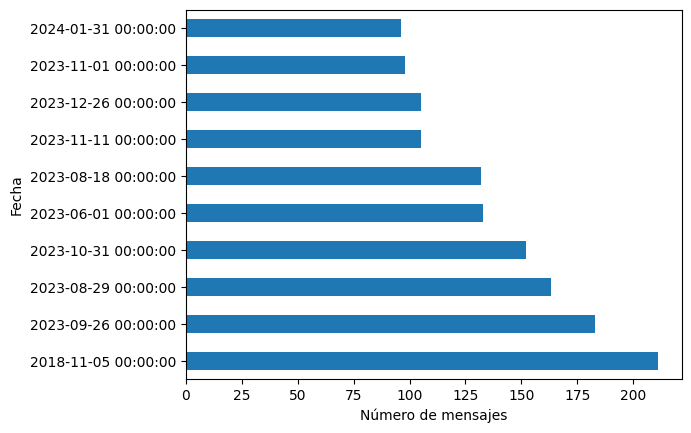

In [29]:
# Determinar los días más activos chat
df['Fecha'].value_counts().head(10).plot.barh() # Plotear 10 días
plt.xlabel('Número de mensajes')
plt.ylabel('Fecha')

Text(0, 0.5, 'Hora')

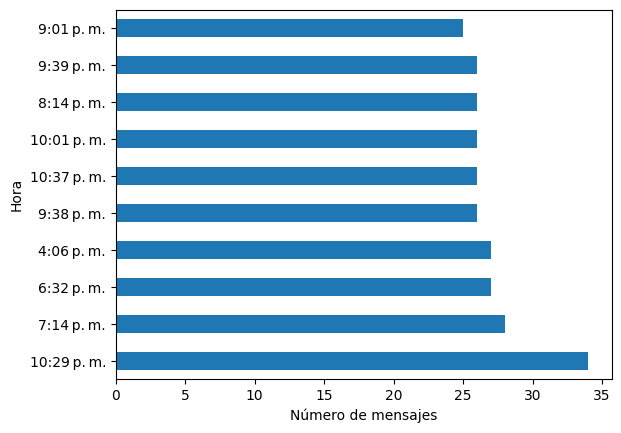

In [31]:
# Determinar las horas en las que el grupo está más activo
df['Hora'].value_counts().head(10).plot.barh() 
plt.xlabel('Número de mensajes')
plt.ylabel('Hora')

## Word Cloud de palabras más usadas por el grupo

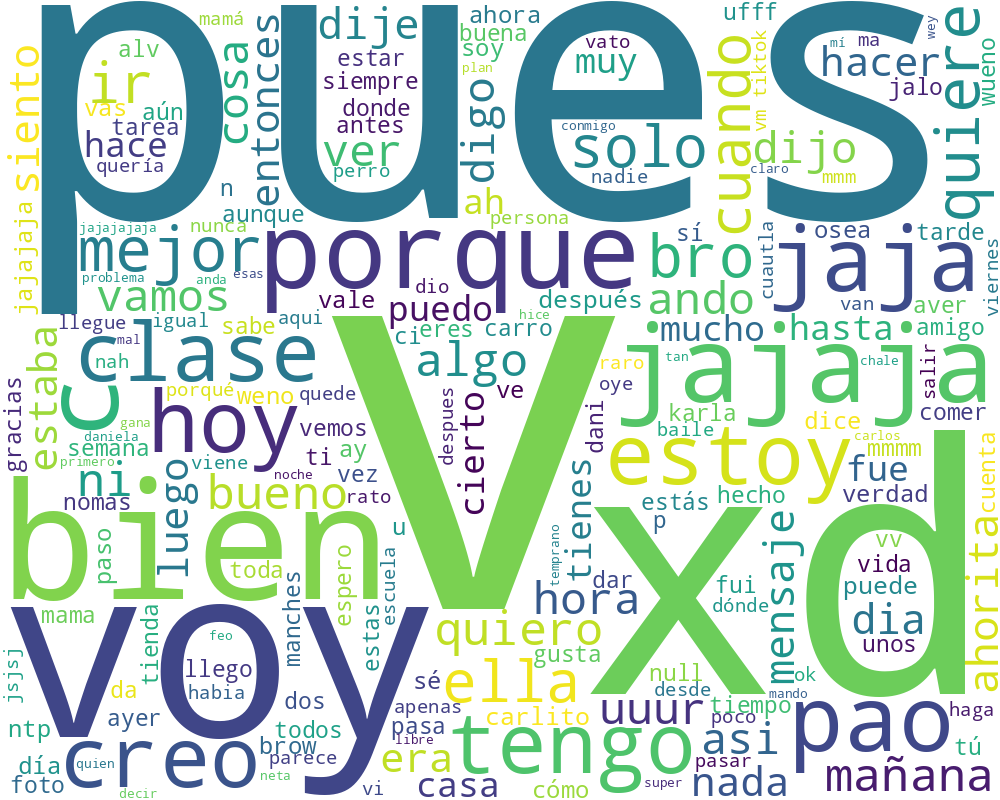

In [32]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es', 
                                                         'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic', 'nos', 'ya', 'hay', 'esta', 
                                                         'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https', 'tu', 'y', 'al',
                                                         'mi', 'tus', 'esa', 'o', 'sus', 'tiene', 'también', 'tambien', 'sea', 'esos', 'esto', 'ese',
                                                         'uno', 'ahi', 'ahí', 'va', 'está', 'yo', 'tenga', 'ser', 'otra', 'otro', 'mis', 'han'])

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in mensajes_df['Mensaje'].values:
  palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
  for palabra in palabras:
    total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(total_palabras) 

# Plotear la nube de palabras más usadas
wordcloud.to_image()